# HW4 : Math for Robotics

Author: Ruffin White  
Course: CSE291  
Date: Mar 9 2018

In [1]:
# Make plots inline
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('png', 'pdf')
# set_matplotlib_formats('png')

# import modules for plotting and data analysis
import matplotlib.pyplot as plt

## 1. 

> Use the ATT dataset http://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att faces.zip. to compute subspaces for the PCA and LDA methods. Provide illustration of the respective 1st, 2nd and 3rd eigenvectors. Compute the recognition rates for the test-set. Report

* Correct classification
* Incorrect classification

> Provide at least one suggestion for how you might improve performance of the system

First we'll import some common numerical libraries, as well as some image, data structure libraries for manipulating the dataset.

In [2]:
import numpy as np
import pandas as pd
import pathlib

from collections import OrderedDict
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

Next we'll add a helper function to recursively search for the face images in the dataset, load them into flatten feature vectors, then interleave them into a dataframe with labels ascertained from the originating directory name.

In [4]:
def read_data(data_dir_path):
    rows = []
    height, width = 112, 92
    flattened = height * width # 10304
    X_keys = ["X_" + str(i) for i in range(flattened)]
    paths = pathlib.Path(data_dir_path).glob('**/*.pgm')
    for path in paths:
        im = Image.open(str(path))
        X_values = np.array(im).flatten()
        y_value = path.parent.name
        row = OrderedDict(zip(X_keys, X_values))
        row['y'] = y_value
        rows.append(row)

    df = pd.DataFrame(rows)
    return df

We then read in the data and split the feature vectors and labels into separate yet commonly indexed dataframes.

In [5]:
data_dir_path = 'data/att_faces/'

df = read_data(data_dir_path)
X = df.drop('y',axis=1)
y = df['y']

We can verify the integrity of the parsed data by recalling the original shape of the images to reshape the flattened features back into the pixelated images they encode, as shown below.

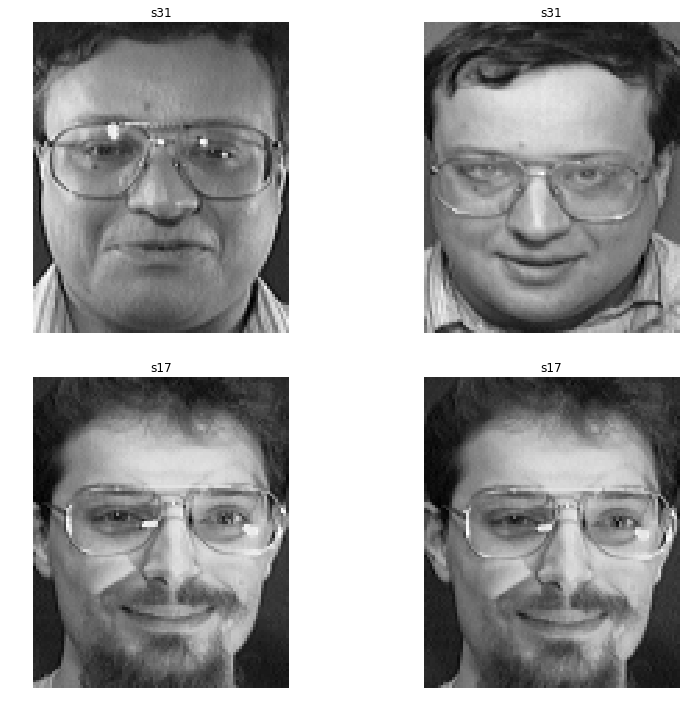

In [6]:
plt.figure(figsize=(12,10))
numbers = [0,1,398,399]
for i in range(4):
    im = X.loc[numbers[i]].values.reshape(112, 92)
    label = y.loc[numbers[i]]
    plt.subplot(2, 2, i+1)
    plt.imshow(im, cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.tight_layout()

Additionally, we can also Standardize the feature vectors. Whether we should standardize the data prior to a PCA depends on the measurement scales of the original features. PCA yields a feature subspace that maximizes the variance along found axes, so it makes sense to standardize the data, especially, if it was measured on different scales (which isn't necessarily the case here given all pixel values fall within a common range). 

This will transform the data onto unit scale (mean=0 and variance=1), which is a common requirement for the optimal performance of many machine learning algorithms. This should also heighten the sensitivity to pixels that change only subtly thought the hole dataset. We will see if this is to our classifiers benefit or detriment later on.

In [7]:
X_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.keys())
# X_std.describe()

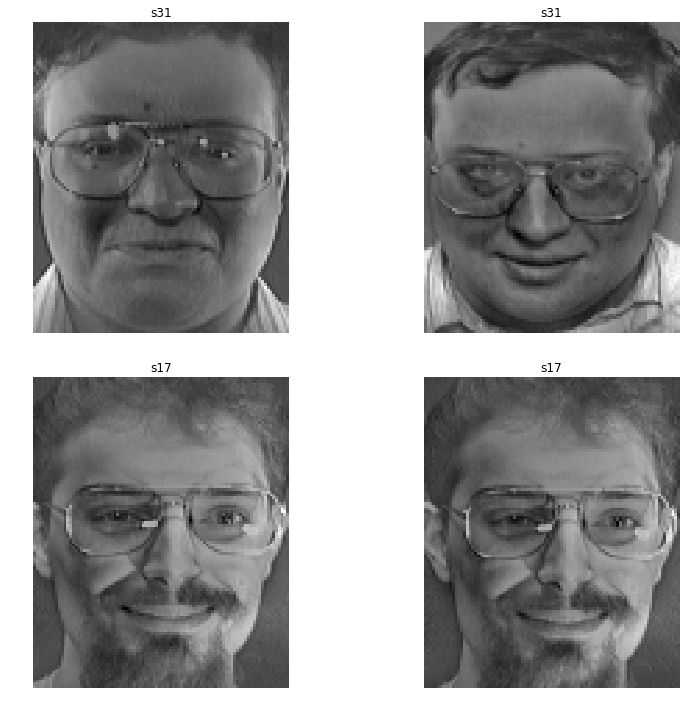

In [8]:
plt.figure(figsize=(12,10))
numbers = [0,1,398,399]
for i in range(4):
    im = X_std.loc[numbers[i]].values.reshape(112, 92)
    label = y.loc[numbers[i]]
    plt.subplot(2, 2, i+1)
    plt.imshow(im, cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.tight_layout()

We now separate our data for train and testing in an 80:20 split, careful to make sure stratify over our labels to ensure all classes are evenaly represented in both training and testing.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import math
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(),
                                                    test_size=0.2, random_state=42, stratify=y)


X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std.as_matrix(), y.as_matrix(),
                                                    test_size=0.2, random_state=42, stratify=y)

Next we fit a PCA model to both our original and standardized training data to determine the dominant eigenvectors for our PCA subspace.

In [10]:
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print('X_std_pca.shape:', X_train_pca.shape)
print('pca.components_:', pca.components_.shape)

pca_std = PCA(n_components=X_std_train.shape[1])
pca_std.fit(X_std_train)
X_std_train_pca = pca_std.transform(X_std_train)

X_std_pca.shape: (320, 320)
pca.components_: (320, 10304)


By extracting the eigenvectors from the fitted model, we can see what they look like in 2D by again reshaping the vecorts for pixel imagery. Below are the eigenvectors for the original data.

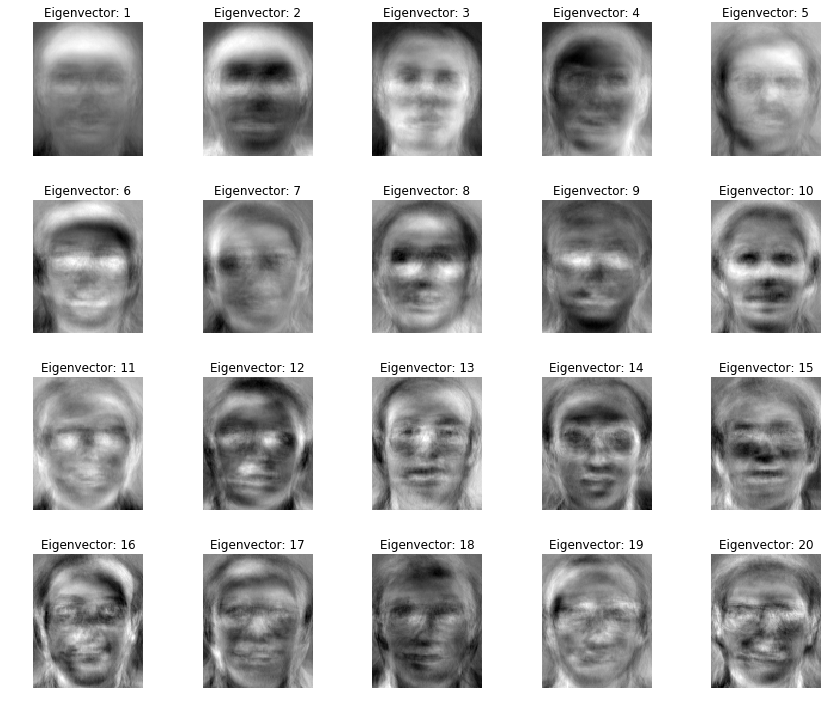

In [11]:
plt.figure(figsize=(12,10))
for i in range(20):
    eigenvector = pca.components_[i].reshape(112, 92)
    plt.subplot(4, 5, i+1)
    plt.imshow(eigenvector, cmap='gray')
    plt.title("Eigenvector: {0}".format(i+1))
    plt.axis("off")
plt.tight_layout()

And below here we see the eigenvectors from the standardized data. Not much of difference for the first few dominate vectors other than shifted bias in grayscale, but smaller vectors seem swap around quite a bit.

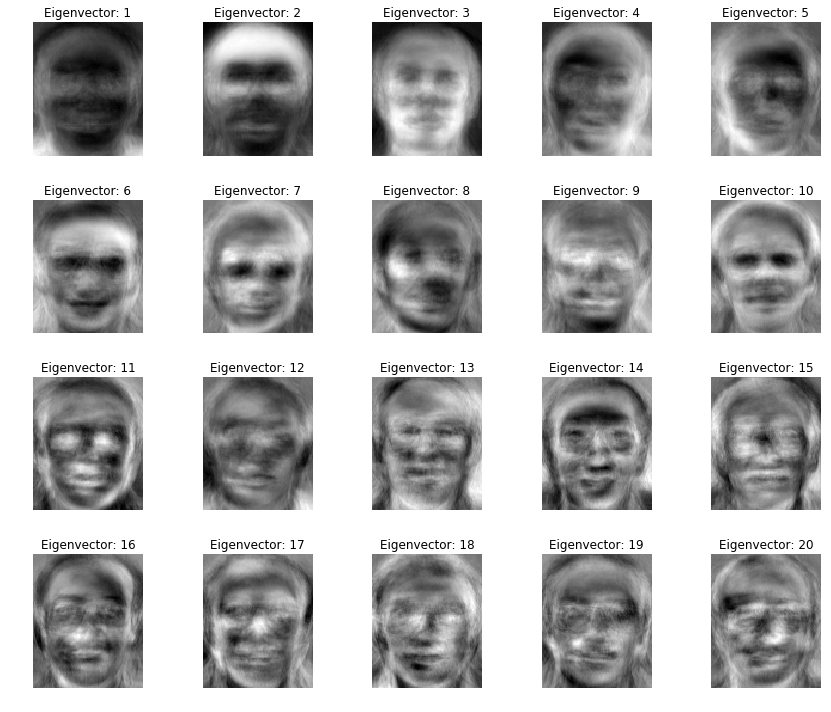

In [12]:
plt.figure(figsize=(12,10))
for i in range(20):
    eigenvector = pca_std.components_[i].reshape(112, 92)
    plt.subplot(4, 5, i+1)
    plt.imshow(eigenvector, cmap='gray')
    plt.title("Eigenvector: {0}".format(i+1))
    plt.axis("off")
plt.tight_layout()

Similarly, we can fit an LDA model on to the original training data a view the coefficients learned.

In [13]:
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

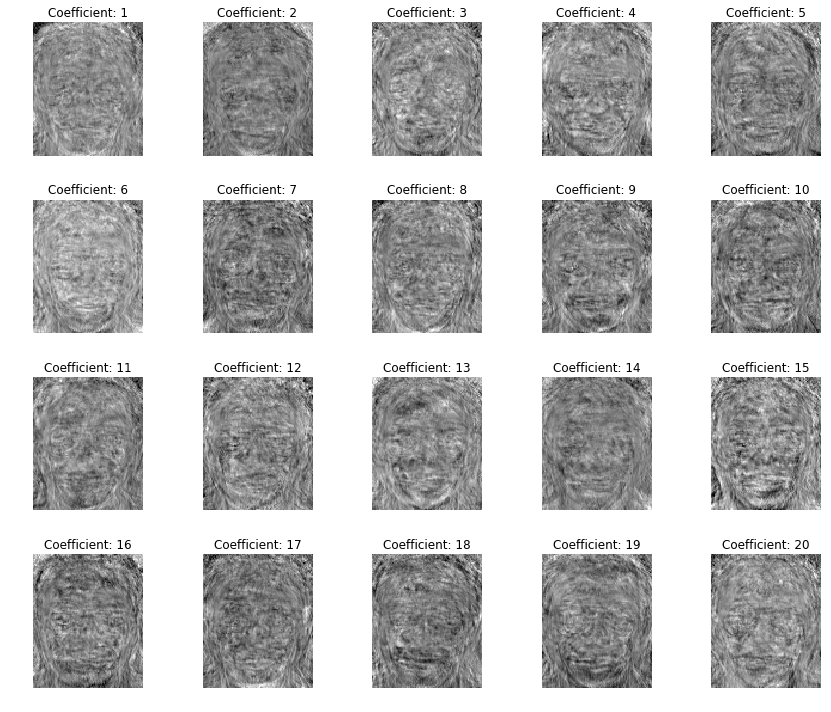

In [14]:
plt.figure(figsize=(12,10))
for i in range(20):
    eigenvector = lda.coef_[i].reshape(112, 92)
    plt.subplot(4, 5, i+1)
    plt.imshow(eigenvector, cmap='gray')
    plt.title("Coefficient: {0}".format(i+1))
    plt.axis("off")
plt.tight_layout()

Again, checking this for the standardized data renders just about the same results, where it appears that the LDA model is picking up on the frequency components of the images that separate the classes the best. Given the small sample sizes per class, I suspect that LDA may be overfitting here. Which leads us to another experimental avenue next.

In [15]:
lda_std = LinearDiscriminantAnalysis()
X_std_train_lda = lda_std.fit_transform(X_std_train, y_std_train)

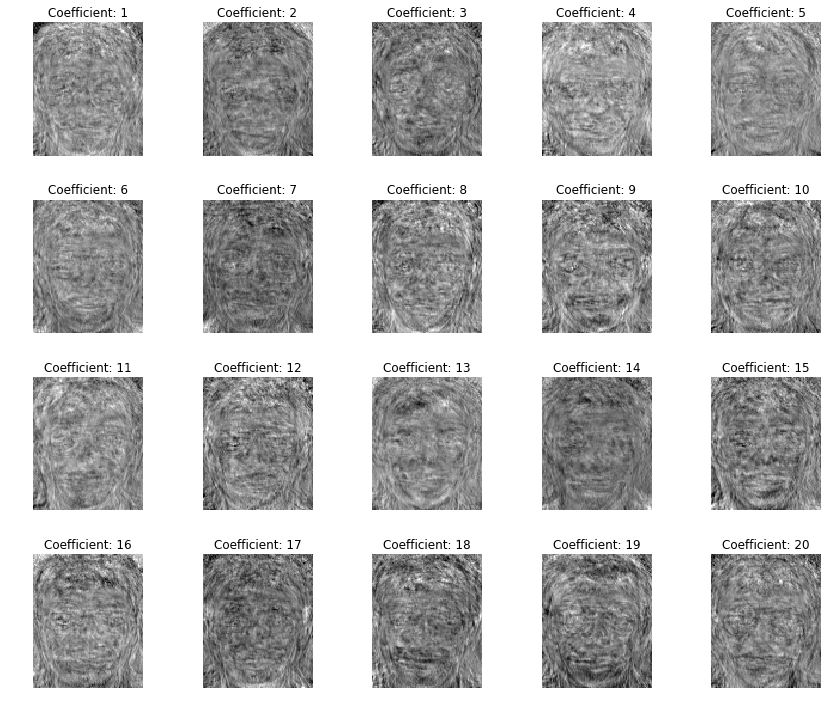

In [16]:
plt.figure(figsize=(12,10))
for i in range(20):
    eigenvector = lda_std.coef_[i].reshape(112, 92)
    plt.subplot(4, 5, i+1)
    plt.imshow(eigenvector, cmap='gray')
    plt.title("Coefficient: {0}".format(i+1))
    plt.axis("off")
plt.tight_layout()

Just for fun, let us also fit an LDA model on the transformed training data acquired from our  first PCA model. We can see below that the LDA coefficients seem to be honeing onto the region of the image that most disittifies the class of the instance, that being the oblong area that contains the faces. It should be noted that proformaing the same method with the standardized data rendering nothing near as instreasing but instead for a few sparse dots, but is perhaps more or less functionally equivalent, but less pronounced.

In [17]:
lda_pca = LinearDiscriminantAnalysis()
X_train_pca_lda = lda_pca.fit_transform(X_train_pca, y_train)

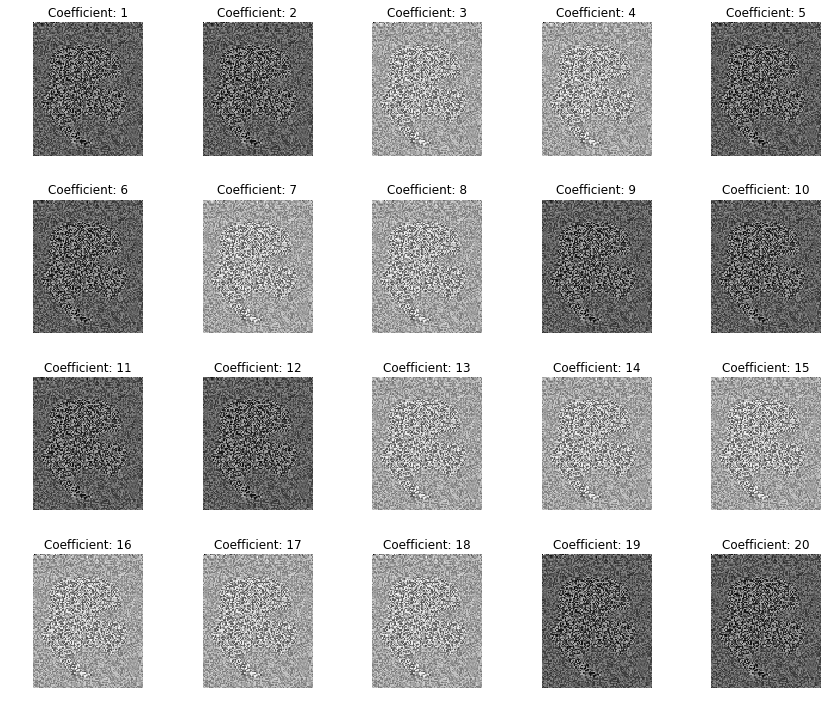

In [18]:
plt.figure(figsize=(12,10))
for i in range(20):
    eigenvector = (pca.inverse_transform(lda_pca.coef_[i])).reshape(112, 92)
    plt.subplot(4, 5, i+1)
    plt.imshow(eigenvector, cmap='gray')
    plt.title("Coefficient: {0}".format(i+1))
    plt.axis("off")
plt.tight_layout()

Now that we have fitted our subspace models, let us now attempt to train a classifier on the projected training data. This we'll use the simple random forest classifier setup for each subspace combination.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rfc = RandomForestClassifier()
rfc_std = RandomForestClassifier()

rfc_pca = RandomForestClassifier()
rfc_lda = RandomForestClassifier()
rfc_lda_pca = RandomForestClassifier()

rfc_std_pca = RandomForestClassifier()
rfc_std_lda = RandomForestClassifier()

In [21]:
rfc.fit(X_train, y_train)
rfc_std.fit(X_std_train, y_std_train)

rfc_pca.fit(X_train_pca, y_train)
rfc_lda.fit(X_train_lda, y_train)
rfc_lda_pca.fit(X_train_pca_lda, y_train)

rfc_std_pca.fit(X_std_train_pca, y_std_train)
rfc_std_lda.fit(X_std_train_lda, y_std_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Next we'll transform the rest of our test data and predict using our list of classifiers.

In [22]:
X_test_pca = pca.transform(X_test)
X_test_lda = lda.transform(X_test)
X_test_pca_lda = lda_pca.transform(X_test_pca)

X_std_test_pca = pca_std.transform(X_std_test)
X_std_test_lda = lda_std.transform(X_std_test)

In [23]:
y_pred = rfc.predict(X_test)
y_std_pred = rfc_std.predict(X_std_test)

y_pred_pca = rfc_pca.predict(X_test_pca)
y_pred_lda = rfc_lda.predict(X_test_lda)
y_pred_pca_lda = rfc_lda_pca.predict(X_test_pca_lda)

y_std_pred_pca = rfc_std_pca.predict(X_std_test_pca)
y_std_pred_lda = rfc_std_lda.predict(X_std_test_lda)

In [24]:
accuracy = confusion_matrix(y_test,y_pred)
accuracy_std = confusion_matrix(y_test,y_std_pred)

accuracy_pca = confusion_matrix(y_test,y_pred_pca)
accuracy_lda = confusion_matrix(y_test,y_pred_lda)
accuracy_pca_lda = confusion_matrix(y_test,y_pred_pca_lda)

accuracy_std_pca = confusion_matrix(y_std_test,y_std_pred_pca)
accuracy_std_lda = confusion_matrix(y_std_test,y_std_pred_lda)

In [25]:
def plot_confusion_matrix(cm, ax,
                          title='Confusion matrix',
                          cmap=None):
    ticks=np.linspace(0, 39,num=40)
    ax.imshow(cm, interpolation='none', cmap=cmap)
#     ax.colorbar()
    plt.xticks(ticks,fontsize=6)
    plt.yticks(ticks,fontsize=6)
    ax.grid(True)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)

Finally, we can plot the confusion matrix over the number of classes to gain qualitative view the accuracy of the various approaches. First shown are the results for PCA with and without standardized data.

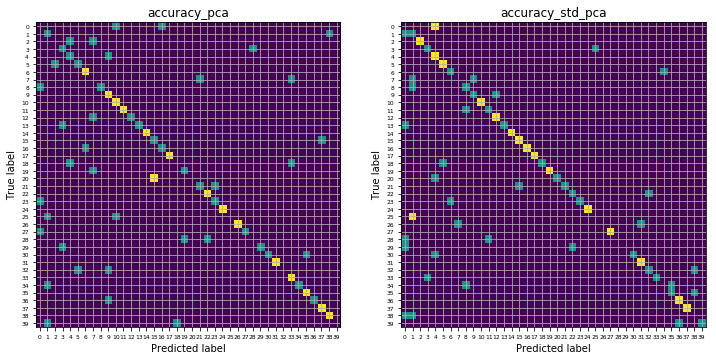

In [26]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,2,1)
plot_confusion_matrix(accuracy_pca, ax, title='accuracy_pca')
ax = fig.add_subplot(1,2,2)
plot_confusion_matrix(accuracy_std_pca, ax, title='accuracy_std_pca')

Next, show here is the same case but for LDA.

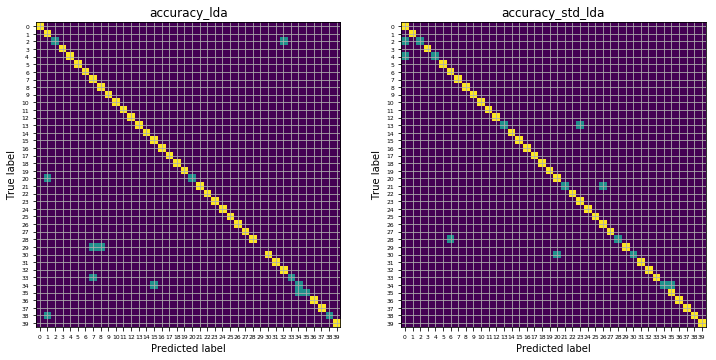

In [27]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,2,1)
plot_confusion_matrix(accuracy_lda, ax, title='accuracy_lda')
ax = fig.add_subplot(1,2,2)
plot_confusion_matrix(accuracy_std_lda, ax, title='accuracy_std_lda')

Lastly is the base case where the data is directly feed to the classifier v.s. our convoluted method of chaining LDA via a prior PCA transform with final random forest classifier fitting with the resulting cascaded output. As we can see this last experimental methods panned out be rather dismal. Additionally the stock methods without any subspace intervention only did slightly worse that the non standardized LDA approach previously.

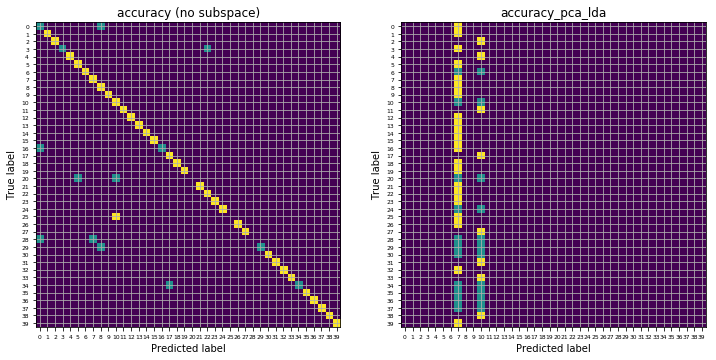

In [28]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,2,1)
plot_confusion_matrix(accuracy, ax, title='accuracy (no subspace)')
ax = fig.add_subplot(1,2,2)
plot_confusion_matrix(accuracy_pca_lda, ax, title='accuracy_pca_lda')

In [29]:
accuracy = accuracy_score(y_test,y_pred)
accuracy_std = accuracy_score(y_test,y_std_pred)

accuracy_pca = accuracy_score(y_test,y_pred_pca)
accuracy_lda = accuracy_score(y_test,y_pred_lda)
accuracy_pca_lda = accuracy_score(y_test,y_pred_pca_lda)

accuracy_std_pca = accuracy_score(y_std_test,y_std_pred_pca)
accuracy_std_lda = accuracy_score(y_std_test,y_std_pred_lda)

In [30]:
from IPython.display import HTML, Latex, display
import tabulate
table = [["Approch","Accuracy"],
         ["RFC PCA",accuracy_pca],
         ["RFC PCA std",accuracy_std_pca],
         ["RFC LDA",accuracy_lda],
         ["RFC LDA std",accuracy_std_lda],
         ["RFC",accuracy],
         ["RFC std",accuracy_std],
         ["RFC LDA PCA",accuracy_pca_lda],
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))
display(Latex(tabulate.tabulate(table, tablefmt='latex')))

<IPython.core.display.Latex object>

In summary, we can see that in most cases, standardizing the data did nothing to help the classification performance, as anticipated given the data was already of the same unit of grayscale intensity. Additionally, RFC LDA appear to be close to just feeding the data directly to the random forest classifier. This could say a few things about the scenario. 

First, that data set is still quite small for modern PCs as opposed to systems back in 1994 when this att dataset was published, thus the bar or necessity for subspace methods has shifted dramatically further given that memory here is not much of an issue. Even with our LDA library using the pseudo inverse to handle the larger number of features vs instances, the majority of the descriptive power can still be ascertained the the RF classifier model. If the dimension of data was larger still, or the sparsity of samples in the feature space was worse, then this could warrant the use of feature space prepsoccessing.

One thing not measured here was the training and evaluation time. Given that the subspace transformation used here does not have an equivalent number of eigenvectors as compared to the dimension of the original feature space, we know the transformation to be inherently lossy. This inevitably leads to reducing the reasoning power from the training data or inference during evaluation.  however if the size of the data set is too large, then reducing the computational complexity by reducing the dimension of the data  can be a suitable compromise.

## 2.

> In robotics sound source localization is a frequent challenge. In the file http://www.hichristensen.com/demo-delay.wav estimate the delay between the two sound channels using FFT. provide an explanation of how you computes the delay between the two channels.

> For both questions provide a description of the approach adopted, the associated code and a description of your results.

To determine the delay between two signals, we’re essentially searching for the phase offset between them. This can be done by checking the cross correlation of one signal with the other. More specifically, this can be done using the FFT by reformulating the convolution operation in the time domain into a single multiplication in the fourier domain. I.e. using the convolution theorem:

$$
\mathcal{F}\{f*g\}=\mathcal{F}\{f\} \cdot \mathcal{F}\{g\}
$$

Thus, we can find the maximum response of the convolution between the two signals, i.e the counter shift rendering the signals in maximum alignment, by taking the argmax over the discrete inverse fourier transform of the product. From this we can determine $k$ in $k \cdot dt$, where $dt$ is the sample period for the discrete signal, $k$ is the number of samples and thus $k \cdot dt$ is the total phase shift in time.

First we import some functions for reading in the WAV file, and calculating the forward and infevers FFT.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from scipy import signal
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy.io import wavfile

We then read in the file and split the two channels. From the stereo format of the file, we'll note the left channel to be the first, and the right channel to be the second, as is conventional in sound engineering and file formats.

In [32]:
fs, data = wavfile.read('data/demo-delay.wav')
L = data.T[0]
R = data.T[1]

From listening to the audio recording using a stereo headset, we can tell from the delay in arrival using our directional sense of hearing that the sound source is seems to originate from the left side from the perspective listener. If we take a look at the start of the signal closely, we can clearly see the subtle time shift with the right channel lagging behind the left.

This makes intuitive sense and matches with our sense of direction given that the time of arrival for a sound source on our left side would sound sooner in our left ear than our right. This ability for sub microsecond phase shift detection is what enables most binaural animals to localize sound sources, often coupled with servoing of the head to more accurately gauge bearing when sensing the change in phase shift over time and orientation.

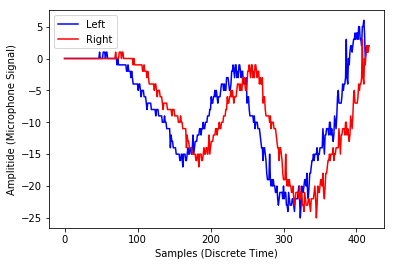

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.array_split(L, 500)[0], 'b', label='Left')
ax.plot(np.array_split(R, 500)[0], 'r', label='Right')
ax.set_xlabel('Samples (Discrete Time)')
ax.set_ylabel('Amplitide (Microphone Signal)')
ax.legend()
plt.show()

Before processing and comparing the audio samples, it is generally a good idea to remove the DC component, as we don't yet exactly know how else the two signals may differ. Here we'll do so by removing the mean average respectively from both channels.

For microphone arrays separated by larger distances or some insulation that would otherwise result in greater signal attenuation in one recorded channel that the other, normalizing each channel by its standard deviation may also be a good idea. As it seems from the figure above that the two signals are of the exact same amplitude, the introduction of smaller floating point computation does not seem necessary in this case.

In [34]:
L = L - L.mean()
# L = L/L.std()
R = R - R.mean()
# R = R/R.std()

We'll use numpy to compute the N-dimensional discrete Fourier Transform for our real input signal. However, to ensure our fft computation is optimized for radix {2, 3, 4, 5}, we must find the next composite of the prime factors 2, 3, and 5 which are greater than or equal to target to pad with zeros, i.e. our maximum discrete sample size of our convolution operation, $|L| + |R| - 1$. This is also known as 5-smooth numbers, regular numbers, or Hamming numbers. We also compute the slice needed for later when shaving off the excess padding from our inverse operation.

Source: https://github.com/scipy/scipy/pull/3144

In [35]:
s1 = np.array(L.shape)
s2 = np.array(R.shape)

shape = s1 + s2 - 1
fshape = [scipy.fftpack.helper.next_fast_len(int(d)) for d in shape]
fslice = tuple([slice(0, int(sz)) for sz in shape])

print("s1: ", s1)
print("s2: ", s2)
print("fshape: ", fshape)
print("fslice: ", fslice)

s1:  [208646]
s2:  [208646]
fshape:  [419904]
fslice:  (slice(0, 417291, None),)


Now we can finally compute the FFT for the left and right channels, we multiply them in the fourier domain, then recover the convolution by taking the reverse FFT of the product. Note that in order to compute the convolution correctly, we must first reverse the kernel, or the right channel in this case, before computing its FFT.

In [36]:
sp1 = np.fft.rfftn(L, fshape)
sp2 = np.fft.rfftn(np.flip(R, axis=0), fshape)
ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice].copy())

We can now plot the response. As shown below, we see the response grow from zero to some nominal noise floor as the kernel convolves over the left channel. From the sharp spike in response just past 200k on the x axis, we can tell that the signals are indeed quite similar, as they best aling at a narrow range in phase offset.

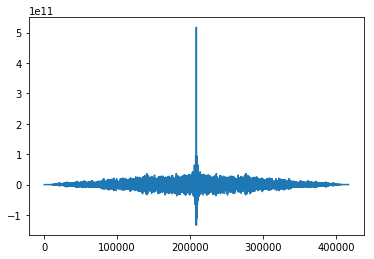

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ret)
# ax.set_yscale("log", nonposy='clip')
plt.show()

We can examine the response closer and see the residual harmonics in the sliding convictions, given the arbitrary waveform my happen to coincide to lesser extents at period lengths of other carrier frequencies of the audible voice sample.

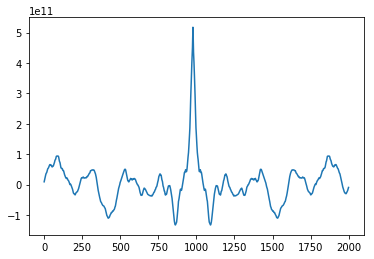

In [38]:
nsamples = L.size

ax = plt.subplot(111)
ax.plot(ret[nsamples-1000:nsamples+1000])
# ax.set_yscale("log", nonposy='clip')
plt.show()

Now, if we use the sample frequency as declared in the metadata of the file, $44.1kHz$ in this case, to derive the sample period $dt$, we can multiple this with $k$ to determine the time shift. Note that we can't really speak of the phase angle, as we are working with arbitrary waveforms that are not composed of a single frequency, thus a single angle would not make sense.

In [39]:
dt = np.arange(1-nsamples, nsamples)
recovered_sample_shift = dt[ret.argmax()]

f = 44.1e3
p = 1/f
recovered_time_shift = recovered_sample_shift * p

print("Recovered shift (samples): ", recovered_sample_shift)
print("Recovered shift (seconds): ", recovered_time_shift)

Recovered shift (samples):  -22
Recovered shift (seconds):  -0.000498866213152


We can do a simple sanity check by multiplying this time by the speed of sound, $343 m/s$  in ambient air temperature to estimate a 'distance' between the two phased array microphones. We find this to be around $\sim17cm$, which is an approximately on the scale for human ear separation, thus why the acoustic delay sound naturally from the left for us.

In [40]:
print("Array Displacement", 343*recovered_time_shift)

Array Displacement -0.171111111111


We can also check this by reversing the shift on the right channel as to realign with the left channel waveform. From the figure below, we see that $k=-22$ does indeed bring the two waveform back info perfect synchrony.

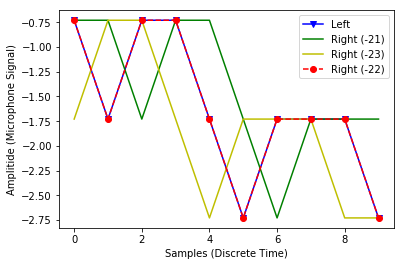

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.array_split(L[0:], 1000)[0][100:110],'bv-', label='Left')
ax.plot(np.array_split(R[21:], 1000)[0][100:110],'g-', label='Right (-21)')
ax.plot(np.array_split(R[23:], 1000)[0][100:110],'y-', label='Right (-23)')
ax.plot(np.array_split(R[22:], 1000)[0][100:110],'ro--', label='Right (-22)')
ax.set_xlabel('Samples (Discrete Time)')
ax.set_ylabel('Amplitide (Microphone Signal)')
ax.legend()
plt.show()